# Plot for high variance vs slow CV. 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

Import general package 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Import Mullerbrown and Overdamped Langevin class 

In [3]:
from potentials.DoubleWellPotential import DoubleWellPotential
from simulations.UnbiasedMD import OverdampedLangevin
from simulations.UnbiasedMD import Langevin

Check if the potentil works fine 

In [4]:
pot = DoubleWellPotential(epsilon=0.05)
pot.set_2D_plot_grid_precision(200, 200)

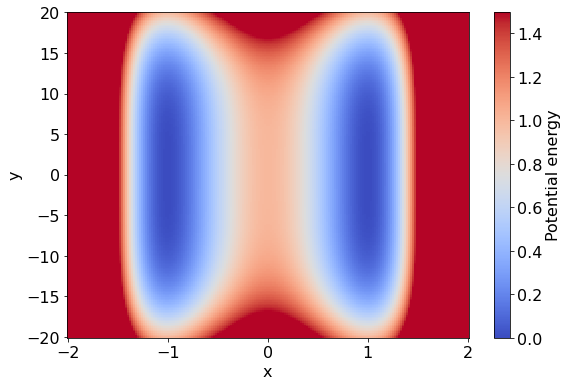

In [5]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("y")
pot_on_grid = pot.V(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)
heatmap= ax.pcolormesh(pot.x_plot,
              pot.y_plot,
              pot_on_grid,
              cmap='coolwarm',
              shading='auto',
              vmin=pot.V_domain[0],
              vmax=pot.V_domain[1])
fig.colorbar(heatmap, ax=ax, label="Potential energy", orientation="vertical") 

In [48]:
beta = 7
dt = 0.01
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**7

In [49]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [50]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [51]:
trajs = np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)
np.savetxt('dataset_DW.txt', trajs)

In [152]:
trajs = np.loadtxt('dataset_DW.txt')
trajs = trajs[np.random.choice(len(trajs), size=2 * 10**6)]

/home/tpigeon/miniconda3/envs/env_ae/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


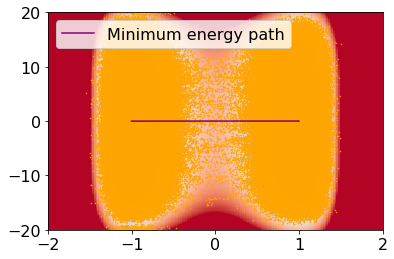

In [153]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.scatter(trajs[:, 0], trajs[:, 1], marker=".", color="orange", s=1)
ax.legend()

In [154]:
dataset = {"boltz_points": trajs}

In [155]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.train_aes import TainAEOneDecoder

In [164]:
del(ae)
del(ae_training)

In [165]:
ae = DeepAutoEncoder([2, 5, 5, 1], [1, 20, 20, 2], 0)
ae_training = TainAEOneDecoder(ae, pot, dataset.copy(), standardize=False, zca_whiten=True)

In [166]:
ae_training.train_test_split(train_size=2 * 10**4)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)
ae_training.set_optimizer('Adam', 0.005)
loss_params = {}
loss_params["mse_boltz_weight"] = 1.0
loss_params["squared_grad_boltz_weight"] = 0. * 10**(-3)
loss_params["n_wait"] = 50
ae_training.set_loss_weight(loss_params)

mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0
pen_points_mse_weight value not provided, set to default value of:  0.0
var_enc_weight value not provided, set to default value of:  0.0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


In [167]:
batch_size = 1000
max_epochs = 1000

In [168]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 291 epochs.



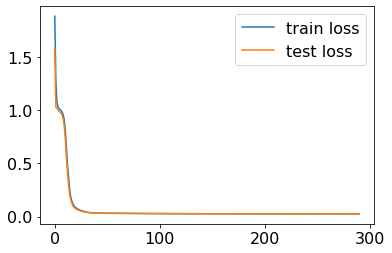

In [169]:
plt.figure()
plt.plot(loss_dict["train_loss"][:], label='train loss')
plt.plot(loss_dict["test_loss"][:], label='test loss')
plt.legend()

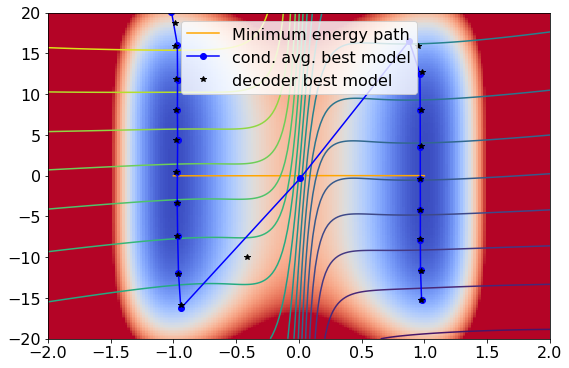

In [170]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
#ax.plot(Esp_X_given_z[:, 0], Esp_X_given_z[:, 1], '-o', color='blue', label='cond. avg. best model')
#ax.plot(f_dec_z[:, 0], f_dec_z[:, 1], '*', color='black', label='decoder best model')
ae_training.plot_encoder_iso_levels(ax, 20)
ae_training.plot_conditional_averages(ax, 20)

ax.legend()

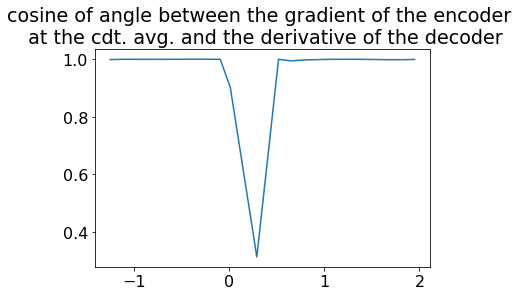

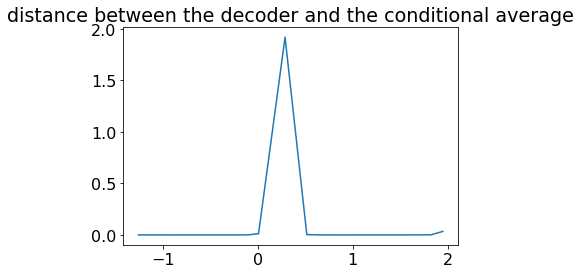

In [171]:
ae_training.plot_principal_curve_convergence(20)